In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'predicta-1-0-predict-the-unpredictable:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F81884%2F8892995%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240621%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240621T064006Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D883430cf4536a23057494c2e32e2c8923b403eb8d6e8ad0ebac46b4768e11526bf238a7630986fc8f54e44db6cd9745e51792046cbd05b27c7cbeabeb8e0bea6881d3017bcce8e54699c2ea70f244e34fb268f0c69bec1e778e26d2da9696b3d6e8ad1aa3518a5304aaf2dee4cfdf501464a9e476e10c8aa4a7aa41c1d5a21858f0201eb76ad978a356408995315c01c070db856d1b1e91d736b948743bb45b441843d53b8462c286e41789c88d2384e9bbc55be7bcb883a5b3a240f367ae2f6c438b65f8329c40a8db2d7b140435529738c2a59f037c7bc347ef343abedea108b2666cc97147ee4ff0bf9e190d92f7406911a59dc28992e6501b97a7111a71c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2038857 bytes downloaded
Downloaded and uncompressed: predicta-1-0-predict-the-unpredictable
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv


In [ ]:
# import the tools we need

# Regular EDA and plotting libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [ ]:
data = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv')
sub_key = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv')
sample_sub = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv')
data.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [ ]:
data.city_id.unique() == sub_key.city_id.unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
data.shape

(182338, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182338 entries, 0 to 182337
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city_id             182338 non-null  object 
 1   date                182338 non-null  object 
 2   avg_temp_c          181114 non-null  float64
 3   min_temp_c          176452 non-null  float64
 4   max_temp_c          174845 non-null  float64
 5   precipitation_mm    112594 non-null  float64
 6   snow_depth_mm       12238 non-null   float64
 7   avg_wind_dir_deg    146944 non-null  float64
 8   avg_wind_speed_kmh  159866 non-null  float64
dtypes: float64(7), object(2)
memory usage: 12.5+ MB


In [ ]:
data.isna().sum()

city_id                    0
date                       0
avg_temp_c              1224
min_temp_c              5886
max_temp_c              7493
precipitation_mm       69744
snow_depth_mm         170100
avg_wind_dir_deg       35394
avg_wind_speed_kmh     22472
dtype: int64

In [ ]:
data.describe()

,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
count,181114.000000,176452.000000,174845.000000,112594.000000,12238.000000,146944.000000,159866.000000
mean,19.137516,14.627775,23.887261,3.679964,342.481696,175.650289,11.281875
std,9.902722,10.004998,10.446670,11.294167,1020.265388,105.435150,6.132884
min,-34.700000,-43.800000,-28.500000,0.000000,0.000000,0.000000,0.000000
25%,12.400000,7.500000,17.100000,0.000000,0.000000,83.000000,7.200000
50%,21.400000,16.200000,27.000000,0.000000,10.000000,178.000000,9.900000
75%,27.100000,23.300000,31.500000,2.300000,140.000000,266.000000,14.000000
max,41.900000,38.900000,49.100000,496.100000,7140.000000,360.000000,80.000000


In [ ]:
data = data.dropna(subset=['avg_temp_c'])
data.isna().sum()

city_id                    0
date                       0
avg_temp_c                 0
min_temp_c              5872
max_temp_c              7470
precipitation_mm       69736
snow_depth_mm         169529
avg_wind_dir_deg       34171
avg_wind_speed_kmh     21312
dtype: int64

In [ ]:
data = data[['city_id','date','avg_temp_c','min_temp_c','max_temp_c']]
data.isna().sum()

city_id          0
date             0
avg_temp_c       0
min_temp_c    5872
max_temp_c    7470
dtype: int64

In [ ]:
data.describe()

,avg_temp_c,min_temp_c,max_temp_c
count,181114.000000,175242.000000,173644.000000
mean,19.137516,14.680485,23.957648
std,9.902722,9.997869,10.417867
min,-34.700000,-43.800000,-28.500000
25%,12.400000,7.500000,17.200000
50%,21.400000,16.300000,27.000000
75%,27.100000,23.300000,31.500000
max,41.900000,38.900000,49.100000


In [ ]:
label_encoder = LabelEncoder()

data['city_id'] = label_encoder.fit_transform(data['city_id'])
sub_key['city_id'] = label_encoder.transform(sub_key['city_id'])

In [ ]:
data['date'] = pd.to_datetime(data['date'])
sub_key['date'] = pd.to_datetime(sub_key['date'])
data.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c
0,0,2014-01-01,6.6,-1.4,11.6
1,0,2014-01-02,9.3,6.3,13.3
2,0,2014-01-03,7.6,1.9,14.0
3,0,2014-01-04,7.6,3.9,13.3
4,0,2014-01-05,8.6,0.5,16.9


In [ ]:
# Extract various date features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_year'] = data['date'].dt.dayofyear
sub_key['year'] = sub_key['date'].dt.year
sub_key['month'] = sub_key['date'].dt.month
sub_key['day'] = sub_key['date'].dt.day
sub_key['day_of_week'] = sub_key['date'].dt.dayofweek
sub_key['day_of_year'] = sub_key['date'].dt.dayofyear
data.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,year,month,day,day_of_week,day_of_year
0,0,2014-01-01,6.6,-1.4,11.6,2014,1,1,2,1
1,0,2014-01-02,9.3,6.3,13.3,2014,1,2,3,2
2,0,2014-01-03,7.6,1.9,14.0,2014,1,3,4,3
3,0,2014-01-04,7.6,3.9,13.3,2014,1,4,5,4
4,0,2014-01-05,8.6,0.5,16.9,2014,1,5,6,5


In [ ]:
data.reset_index(drop=True, inplace=True)
data.tail()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,year,month,day,day_of_week,day_of_year
181109,99,2018-12-27,22.0,15.9,27.9,2018,12,27,3,361
181110,99,2018-12-28,21.9,14.9,28.2,2018,12,28,4,362
181111,99,2018-12-29,22.4,16.3,28.2,2018,12,29,5,363
181112,99,2018-12-30,21.6,18.5,26.6,2018,12,30,6,364
181113,99,2018-12-31,20.2,17.1,25.0,2018,12,31,0,365


In [ ]:
split_index = len(sub_key)
split_index

700

In [ ]:
merged_data = pd.concat([data, sub_key], axis=0)
merged_data.reset_index(drop=True, inplace=True)

In [ ]:
merged_data.tail()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,year,month,day,day_of_week,day_of_year,submission_ID
181809,99,2019-01-03,NaN,NaN,NaN,2019,1,3,3,3,696.0
181810,99,2019-01-04,NaN,NaN,NaN,2019,1,4,4,4,697.0
181811,99,2019-01-05,NaN,NaN,NaN,2019,1,5,5,5,698.0
181812,99,2019-01-06,NaN,NaN,NaN,2019,1,6,6,6,699.0
181813,99,2019-01-07,NaN,NaN,NaN,2019,1,7,0,7,700.0


In [ ]:
# Group by city_id
grouped = merged_data.groupby('city_id')
grouped.tail()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,year,month,day,day_of_week,day_of_year,submission_ID
181116,0,2019-01-03,NaN,NaN,NaN,2019,1,3,3,3,3.0
181117,0,2019-01-04,NaN,NaN,NaN,2019,1,4,4,4,4.0
181118,0,2019-01-05,NaN,NaN,NaN,2019,1,5,5,5,5.0
181119,0,2019-01-06,NaN,NaN,NaN,2019,1,6,6,6,6.0
181120,0,2019-01-07,NaN,NaN,NaN,2019,1,7,0,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...
181809,99,2019-01-03,NaN,NaN,NaN,2019,1,3,3,3,696.0
181810,99,2019-01-04,NaN,NaN,NaN,2019,1,4,4,4,697.0
181811,99,2019-01-05,NaN,NaN,NaN,2019,1,5,5,5,698.0
181812,99,2019-01-06,NaN,NaN,NaN,2019,1,6,6,6,699.0


In [ ]:
def impute_group(group):

  # Compute historical means for the same day in previous years
    group['historical_mean'] = group.groupby('day_of_year')['avg_temp_c'].transform('mean')
    group['historical_max'] = group.groupby('day_of_year')['max_temp_c'].transform('mean')
    group['historical_min'] = group.groupby('day_of_year')['min_temp_c'].transform('mean')
    group['historical_max'].fillna(group['historical_max'].mean(), inplace=True)
    group['historical_min'].fillna(group['historical_min'].mean(), inplace=True)

    # Compute rolling means for min and max temperatures excluding the current day
    group['min_temp_c_rolling_mean_7'] = group['min_temp_c'].shift(7).rolling(window=7).mean()
    group['max_temp_c_rolling_mean_7'] = group['max_temp_c'].shift(7).rolling(window=7).mean()

    group.drop(columns=['min_temp_c','max_temp_c'], inplace=True)

    # Fill rolling means with the mean of rolling means
    group['min_temp_c_rolling_mean_7'].fillna(group['min_temp_c_rolling_mean_7'].mean(), inplace=True)
    group['max_temp_c_rolling_mean_7'].fillna(group['max_temp_c_rolling_mean_7'].mean(), inplace=True)

    # Compute rolling means for the last days excluding the current day
    group['avg_temp_c_rolling_mean_3'] = group['avg_temp_c'].shift(7).rolling(window=3).mean()
    group['avg_temp_c_rolling_mean_5'] = group['avg_temp_c'].shift(7).rolling(window=5).mean()
    group['avg_temp_c_rolling_mean_7'] = group['avg_temp_c'].shift(7).rolling(window=7).mean()
    group['avg_temp_c_rolling_mean_14'] = group['avg_temp_c'].shift(7).rolling(window=14).mean()
    group['avg_temp_c_rolling_mean_30'] = group['avg_temp_c'].shift(7).rolling(window=30).mean()
    group['avg_temp_c_rolling_mean_60'] = group['avg_temp_c'].shift(7).rolling(window=60).mean()
    group['avg_temp_c_rolling_mean_180'] = group['avg_temp_c'].shift(7).rolling(window=180).mean()

    # Fill rolling means with the mean of rolling means
    group['avg_temp_c_rolling_mean_3'].fillna(group['avg_temp_c_rolling_mean_3'].mean(), inplace=True)
    group['avg_temp_c_rolling_mean_5'].fillna(group['avg_temp_c_rolling_mean_5'].mean(), inplace=True)
    group['avg_temp_c_rolling_mean_7'].fillna(group['avg_temp_c_rolling_mean_7'].mean(), inplace=True)
    group['avg_temp_c_rolling_mean_14'].fillna(group['avg_temp_c_rolling_mean_14'].mean(), inplace=True)
    group['avg_temp_c_rolling_mean_30'].fillna(group['avg_temp_c_rolling_mean_30'].mean(), inplace=True)
    group['avg_temp_c_rolling_mean_60'].fillna(group['avg_temp_c_rolling_mean_60'].mean(), inplace=True)
    group['avg_temp_c_rolling_mean_180'].fillna(group['avg_temp_c_rolling_mean_180'].mean(), inplace=True)

    # Compute historical means for the same day in previous years
    group['day_of_year'] = group['date'].dt.dayofyear
    group['historical_mean'] = group.groupby('day_of_year')['avg_temp_c'].transform('mean')

    return group

In [ ]:
# Apply imputation and feature engineering to each group
merge_data_imputed = grouped.apply(impute_group)
merge_data_imputed.reset_index(drop=True, inplace=True)
merge_data_imputed['year'] = label_encoder.fit_transform(merge_data_imputed['year'])
merge_data_imputed.head(8)

,city_id,date,avg_temp_c,year,month,day,day_of_week,day_of_year,submission_ID,historical_mean,...,historical_min,min_temp_c_rolling_mean_7,max_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_3,avg_temp_c_rolling_mean_5,avg_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_14,avg_temp_c_rolling_mean_30,avg_temp_c_rolling_mean_60,avg_temp_c_rolling_mean_180
0,0,2014-01-01,6.6,0,1,1,2,1,NaN,6.78,...,-0.20,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377
1,0,2014-01-02,9.3,0,1,2,3,2,NaN,6.66,...,0.12,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377
2,0,2014-01-03,7.6,0,1,3,4,3,NaN,7.62,...,1.90,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377
3,0,2014-01-04,7.6,0,1,4,5,4,NaN,7.44,...,3.38,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377
4,0,2014-01-05,8.6,0,1,5,6,5,NaN,7.56,...,1.60,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377
5,0,2014-01-06,9.1,0,1,6,0,6,NaN,7.40,...,3.00,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377
6,0,2014-01-07,8.8,0,1,7,1,7,NaN,6.50,...,1.68,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377
7,0,2014-01-08,8.8,0,1,8,2,8,NaN,6.34,...,1.26,10.152579,23.510728,16.306396,16.314457,16.322449,16.350701,16.408755,16.519231,16.599377


In [ ]:
cols_to_scale = ['historical_mean','historical_max','historical_min','min_temp_c_rolling_mean_7','max_temp_c_rolling_mean_7','avg_temp_c_rolling_mean_3','avg_temp_c_rolling_mean_5','avg_temp_c_rolling_mean_7','avg_temp_c_rolling_mean_14','avg_temp_c_rolling_mean_30'	,'avg_temp_c_rolling_mean_180','avg_temp_c_rolling_mean_60']

merge_data_imputed_sub = merge_data_imputed[cols_to_scale]

scaler = StandardScaler()

scaler.fit(merge_data_imputed_sub)

merge_data_scaled = scaler.transform(merge_data_imputed_sub)

merge_data_imputed[cols_to_scale] = merge_data_scaled
merge_data_imputed.head()

,city_id,date,avg_temp_c,year,month,day,day_of_week,day_of_year,submission_ID,historical_mean,...,historical_min,min_temp_c_rolling_mean_7,max_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_3,avg_temp_c_rolling_mean_5,avg_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_14,avg_temp_c_rolling_mean_30,avg_temp_c_rolling_mean_60,avg_temp_c_rolling_mean_180
0,0,2014-01-01,6.6,0,1,1,2,1,NaN,-1.280553,...,-1.543472,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
1,0,2014-01-02,9.3,0,1,2,3,2,NaN,-1.293009,...,-1.510412,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
2,0,2014-01-03,7.6,0,1,3,4,3,NaN,-1.193361,...,-1.326515,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
3,0,2014-01-04,7.6,0,1,4,5,4,NaN,-1.212045,...,-1.173611,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
4,0,2014-01-05,8.6,0,1,5,6,5,NaN,-1.199589,...,-1.357508,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439


In [ ]:
# merge_data_imputed = merge_data_imputed.drop(columns=['precipitation_mm', 'day', 'month_cos', 'day_of_week_cos',
#                                                       'month','month','day_of_week','day_of_year',
#                                                       'month_sin', 'day_of_week_sin'])

In [ ]:
sub_key = merge_data_imputed[merge_data_imputed['year'] == 5]
sub_key.reset_index(drop=True, inplace=True)
sub_key.head()

,city_id,date,avg_temp_c,year,month,day,day_of_week,day_of_year,submission_ID,historical_mean,...,historical_min,min_temp_c_rolling_mean_7,max_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_3,avg_temp_c_rolling_mean_5,avg_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_14,avg_temp_c_rolling_mean_30,avg_temp_c_rolling_mean_60,avg_temp_c_rolling_mean_180
0,0,2019-01-01,NaN,5,1,1,1,1,1.0,-1.280553,...,-1.543472,-1.260347,-0.832655,-1.016752,-1.111640,-1.135588,-0.868184,-0.867980,-0.701526,0.009492
1,0,2019-01-02,NaN,5,1,2,2,2,2.0,-1.293009,...,-1.510412,-1.275209,-0.803936,-1.006560,-1.052201,-1.120892,-0.865960,-0.865174,-0.714665,-0.003342
2,0,2019-01-03,NaN,5,1,3,3,3,3.0,-1.193361,...,-1.326515,-1.230625,-0.775217,-0.996367,-1.007109,-1.079741,-0.858547,-0.861315,-0.726904,-0.015568
3,0,2019-01-04,NaN,5,1,4,4,4,4.0,-1.212045,...,-1.173611,-1.160777,-0.746498,-0.958994,-0.986613,-1.026832,-0.880046,-0.846581,-0.736083,-0.027592
4,0,2019-01-05,NaN,5,1,5,5,5,5.0,-1.199589,...,-1.357508,-1.116193,-0.703420,-0.975982,-0.996861,-1.006257,-0.934908,-0.837460,-0.747602,-0.040628


In [ ]:
# Get the rest of the data (excluding year 2019)
data_imputed = merge_data_imputed[merge_data_imputed['year'] != 5]
data_imputed.tail()

,city_id,date,avg_temp_c,year,month,day,day_of_week,day_of_year,submission_ID,historical_mean,...,historical_min,min_temp_c_rolling_mean_7,max_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_3,avg_temp_c_rolling_mean_5,avg_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_14,avg_temp_c_rolling_mean_30,avg_temp_c_rolling_mean_60,avg_temp_c_rolling_mean_180
181802,99,2018-12-27,22.0,4,12,27,3,361,NaN,0.380250,...,0.260374,0.298602,0.061934,0.151996,0.161175,0.162136,0.162322,0.154638,0.194786,-0.061095
181803,99,2018-12-28,21.9,4,12,28,4,362,NaN,0.438378,...,0.229380,0.298602,0.028908,0.104431,0.130431,0.137152,0.156391,0.149375,0.187587,-0.057245
181804,99,2018-12-29,22.4,4,12,29,5,363,NaN,0.336654,...,0.309964,0.280768,-0.004119,0.043275,0.079190,0.106289,0.146753,0.141307,0.179307,-0.053462
181805,99,2018-12-30,21.6,4,12,30,6,364,NaN,0.303438,...,0.268639,0.228754,-0.009863,-0.014483,0.052545,0.085713,0.141564,0.135343,0.173728,-0.048869
181806,99,2018-12-31,20.2,4,12,31,0,365,NaN,0.305514,...,0.225248,0.181198,0.015984,0.033083,0.058694,0.079834,0.140081,0.132186,0.169768,-0.042925


In [ ]:
sub_key.isna().sum()

city_id                          0
date                             0
avg_temp_c                     700
year                             0
month                            0
day                              0
day_of_week                      0
day_of_year                      0
submission_ID                    0
historical_mean                  0
historical_max                   0
historical_min                   0
min_temp_c_rolling_mean_7        0
max_temp_c_rolling_mean_7        0
avg_temp_c_rolling_mean_3        0
avg_temp_c_rolling_mean_5        0
avg_temp_c_rolling_mean_7        0
avg_temp_c_rolling_mean_14       0
avg_temp_c_rolling_mean_30       0
avg_temp_c_rolling_mean_60       0
avg_temp_c_rolling_mean_180      0
dtype: int64

In [ ]:
# sub_key['avg_temp_c_lag_1'].fillna(method='ffill', inplace=True)
# sub_key['avg_temp_c_lag_2'].fillna(method='ffill', inplace=True)
# sub_key.isna().sum()

In [ ]:
data_imputed.isna().sum()

city_id                             0
date                                0
avg_temp_c                          0
year                                0
month                               0
day                                 0
day_of_week                         0
day_of_year                         0
submission_ID                  181114
historical_mean                     0
historical_max                      0
historical_min                      0
min_temp_c_rolling_mean_7           0
max_temp_c_rolling_mean_7           0
avg_temp_c_rolling_mean_3           0
avg_temp_c_rolling_mean_5           0
avg_temp_c_rolling_mean_7           0
avg_temp_c_rolling_mean_14          0
avg_temp_c_rolling_mean_30          0
avg_temp_c_rolling_mean_60          0
avg_temp_c_rolling_mean_180         0
dtype: int64

In [ ]:
data_imputed = data_imputed.drop(columns=['submission_ID'])
data_imputed.head()

,city_id,date,avg_temp_c,year,month,day,day_of_week,day_of_year,historical_mean,historical_max,historical_min,min_temp_c_rolling_mean_7,max_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_3,avg_temp_c_rolling_mean_5,avg_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_14,avg_temp_c_rolling_mean_30,avg_temp_c_rolling_mean_60,avg_temp_c_rolling_mean_180
0,0,2014-01-01,6.6,0,1,1,2,1,-1.280553,-0.944175,-1.543472,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
1,0,2014-01-02,9.3,0,1,2,3,2,-1.293009,-0.920121,-1.510412,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
2,0,2014-01-03,7.6,0,1,3,4,3,-1.193361,-0.938162,-1.326515,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
3,0,2014-01-04,7.6,0,1,4,5,4,-1.212045,-1.134605,-1.173611,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439
4,0,2014-01-05,8.6,0,1,5,6,5,-1.199589,-0.976248,-1.357508,-0.486549,-0.048991,-0.28903,-0.29031,-0.291154,-0.292807,-0.295936,-0.300789,-0.337439


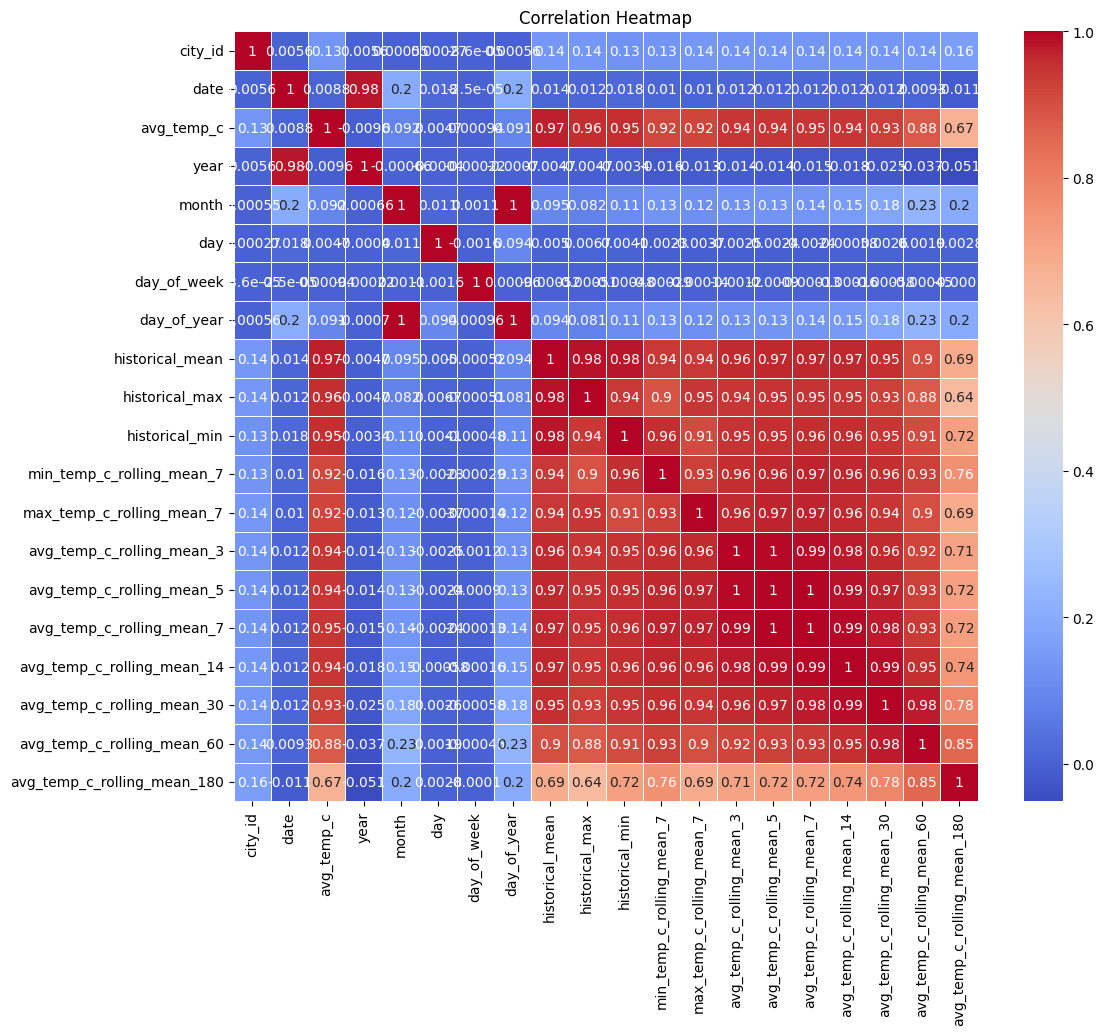

In [ ]:
# Compute the correlation matrix
corr_matrix = data_imputed.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set title
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

In [ ]:
data_imputed.isna().sum()

city_id                        0
date                           0
avg_temp_c                     0
year                           0
month                          0
day                            0
day_of_week                    0
day_of_year                    0
historical_mean                0
historical_max                 0
historical_min                 0
min_temp_c_rolling_mean_7      0
max_temp_c_rolling_mean_7      0
avg_temp_c_rolling_mean_3      0
avg_temp_c_rolling_mean_5      0
avg_temp_c_rolling_mean_7      0
avg_temp_c_rolling_mean_14     0
avg_temp_c_rolling_mean_30     0
avg_temp_c_rolling_mean_60     0
avg_temp_c_rolling_mean_180    0
dtype: int64

In [ ]:
# Define the first week of January for 2017 and 2018
validation_dates = (data_imputed['date'].dt.year.isin([2018])) & (data_imputed['date'].dt.dayofyear <= 7)

# Split into training and validation sets based on the date
X_val = data_imputed.loc[validation_dates, ['city_id','day_of_year','historical_mean', 'historical_max', 'historical_min',
                                            'min_temp_c_rolling_mean_7', 'max_temp_c_rolling_mean_7',
                                            'avg_temp_c_rolling_mean_3', 'avg_temp_c_rolling_mean_5',
                                            'avg_temp_c_rolling_mean_7', 'avg_temp_c_rolling_mean_14',
                                            'avg_temp_c_rolling_mean_30', 'avg_temp_c_rolling_mean_180',
                                            'avg_temp_c_rolling_mean_60']]
y_val = data_imputed.loc[validation_dates, 'avg_temp_c']

X_train = data_imputed.loc[~validation_dates, ['city_id','day_of_year','historical_mean', 'historical_max', 'historical_min',
                                               'min_temp_c_rolling_mean_7', 'max_temp_c_rolling_mean_7',
                                               'avg_temp_c_rolling_mean_3', 'avg_temp_c_rolling_mean_5',
                                               'avg_temp_c_rolling_mean_7', 'avg_temp_c_rolling_mean_14',
                                               'avg_temp_c_rolling_mean_30', 'avg_temp_c_rolling_mean_180',
                                               'avg_temp_c_rolling_mean_60']]
y_train = data_imputed.loc[~validation_dates, 'avg_temp_c']

# Standardize features, dropping the date column for scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
5638/5638 [==============================] - 12s 2ms/step - loss: 9.9074 - val_loss: 6.7978
Epoch 2/100
5638/5638 [==============================] - 12s 2ms/step - loss: 5.5645 - val_loss: 10.7271
Epoch 3/100
5638/5638 [==============================] - 11s 2ms/step - loss: 5.5003 - val_loss: 8.3340
Epoch 4/100
5638/5638 [==============================] - 10s 2ms/step - loss: 5.4708 - val_loss: 8.1662
Epoch 5/100
5638/5638 [==============================] - 12s 2ms/step - loss: 5.4347 - val_loss: 8.5039
Epoch 6/100
5638/5638 [==============================] - 12s 2ms/step - loss: 5.4100 - val_loss: 7.9332
Epoch 7/100
5638/5638 [==============================] - 12s 2ms/step - loss: 5.3925 - val_loss: 8.2129
Epoch 8/100
5638/5638 [==============================] - 12s 2ms/step - loss: 5.3580 - val_loss: 7.7434
Epoch 9/100
5638/5638 [==============================] - 12s 2ms/step - loss: 5.3196 - val_loss: 8.6766
Epoch 10/100
5638/5638 [==============================] - 11s 2

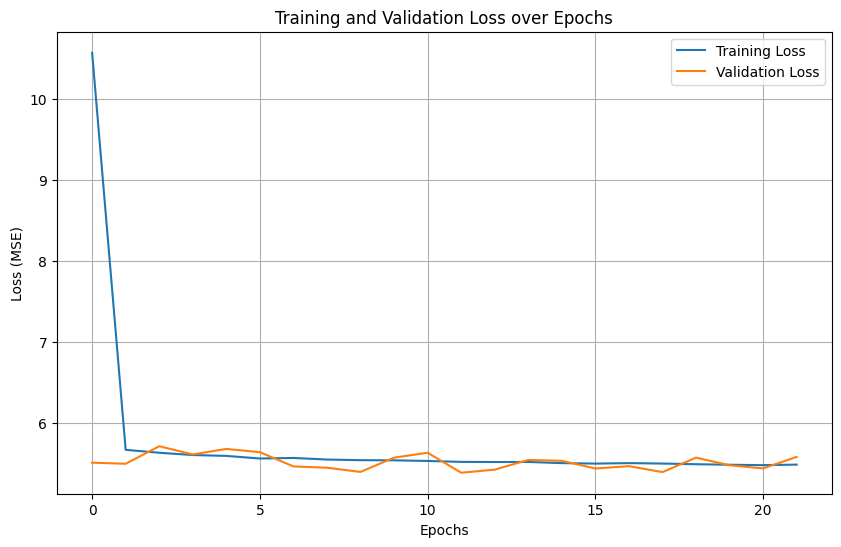

In [ ]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on validation data
y_pred = model.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Validation RMSE: {rmse:.2f} Celsius')

22/22 [==============================] - 0s 2ms/step
Validation RMSE: 2.58 Celsius


In [ ]:
sub_key.head()

,city_id,date,avg_temp_c,year,month,day,day_of_week,day_of_year,submission_ID,historical_mean,...,historical_min,min_temp_c_rolling_mean_7,max_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_3,avg_temp_c_rolling_mean_5,avg_temp_c_rolling_mean_7,avg_temp_c_rolling_mean_14,avg_temp_c_rolling_mean_30,avg_temp_c_rolling_mean_60,avg_temp_c_rolling_mean_180
0,0,2019-01-01,NaN,5,1,1,1,1,1.0,-1.280553,...,-1.543472,-1.260347,-0.832655,-1.016752,-1.111640,-1.135588,-0.868184,-0.867980,-0.701526,0.009492
1,0,2019-01-02,NaN,5,1,2,2,2,2.0,-1.293009,...,-1.510412,-1.275209,-0.803936,-1.006560,-1.052201,-1.120892,-0.865960,-0.865174,-0.714665,-0.003342
2,0,2019-01-03,NaN,5,1,3,3,3,3.0,-1.193361,...,-1.326515,-1.230625,-0.775217,-0.996367,-1.007109,-1.079741,-0.858547,-0.861315,-0.726904,-0.015568
3,0,2019-01-04,NaN,5,1,4,4,4,4.0,-1.212045,...,-1.173611,-1.160777,-0.746498,-0.958994,-0.986613,-1.026832,-0.880046,-0.846581,-0.736083,-0.027592
4,0,2019-01-05,NaN,5,1,5,5,5,5.0,-1.199589,...,-1.357508,-1.116193,-0.703420,-0.975982,-0.996861,-1.006257,-0.934908,-0.837460,-0.747602,-0.040628


In [ ]:
X_test = sub_key[['historical_mean','historical_max','historical_min','min_temp_c_rolling_mean_7','max_temp_c_rolling_mean_7','avg_temp_c_rolling_mean_3','avg_temp_c_rolling_mean_5','avg_temp_c_rolling_mean_7','avg_temp_c_rolling_mean_14','avg_temp_c_rolling_mean_30'	,'avg_temp_c_rolling_mean_180','avg_temp_c_rolling_mean_60']]
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Make predictions
predictions = model.predict(X_test_scaled).flatten()

22/22 [==============================] - 0s 2ms/step


In [ ]:
submission = sample_sub.copy()
submission['avg_temp_c'] = predictions

In [ ]:
submission.head(7)

,submission_ID,avg_temp_c
0,1,6.567129
1,2,6.603112
2,3,7.273652
3,4,6.974383
4,5,7.000414
5,6,6.842872
6,7,6.367219


In [ ]:
# Save submission file
submission.to_csv('submission.csv', index=False)
print('Submission file saved successfully.')

Submission file saved successfully.


In [ ]:
data.tail()